In [25]:
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from io import StringIO

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import skbio
from skbio import diversity
from skbio.stats import ordination
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist

## Read data

In [2]:
otus = pd.read_csv("../data/otus.csv")
comp = pd.read_csv("../data/comp.csv")

In [12]:
# beta_diversity, get_beta_diversity_metrics
# cca
# MDS(metric=False)

## Prepare OTU-sample table and sequences for phylogenetic tree

In [72]:
def get_silva_taxonomy(taxa_raw: list):
    domain = None
    for i in range(len(taxa_raw)):
        if taxa_raw[i].startswith("\tsilva"):
            domain = taxa_raw[i].split("|")[-1]
            break
    taxa = {"domain": domain}
    tunits = ["phylum", "class", "order", "family", "genus"]
    for unit in tunits:
        taxa[unit] = None
    for unit, value in zip(tunits, taxa_raw[i + 1:]):
        taxa[unit] = value
    return taxa

In [99]:
otus_taxa = pd.DataFrame(otus.taxonomy.str.split("&").apply(get_silva_taxonomy).tolist())
otus_full = pd.concat([otus, otus_taxa], axis=1)
otus_core = otus_full[["domain", "phylum", "class", "order", "family", "genus", "sequence"]]
print(otus_core.shape)
otus_core = otus_core.drop_duplicates(["domain", "phylum", "class", "order", "family", "genus"])
otus_core["OTU"] = np.arange(1, otus_core.shape[0] + 1)
otus_core["OTU"] = otus_core["OTU"].apply(lambda x: f"OTU_{x}")
print(otus_core.shape)
otus_core.head()

(36834, 7)
(1257, 8)


,domain,phylum,class,order,family,genus,sequence,OTU
0,Bacteria,Caldatribacteriota,JS1,None,None,None,TACATAAGGAGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCT...,OTU_1
7,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2
9,Bacteria,Actinobacteriota,Thermoleophilia,Gaiellales,Gaiellaceae,Gaiella,TACGTAGGGGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGAGCG...,OTU_3
14,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4
16,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,None,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5


In [108]:
comp_full = pd.merge(comp, otus_core, "left", on=["domain", "phylum", "class", "order", "family", "genus"])
comp_full

,2cm Gotland,20cm Gotland,40cm Gotland,80cm Gotland,120cm Gotland,145cm Gotland,185cm Gotland,220cm Gotland,270cm Gotland,2cm Fin,...,150cm Fin,190cm Fin,domain,phylum,class,order,family,genus,sequence,OTU
0,10.46120,1.1149,1.00465,0.54855,0.29410,0.91300,1.27650,0.89165,1.10160,2.25905,...,2.93200,14.38855,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4
1,3.50275,0.4323,0.23410,0.23175,0.11385,0.23995,0.38340,0.37140,0.16495,0.37970,...,0.25725,1.48010,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,Solirubrobacteraceae,Conexibacter,TACGTAGGGTACAAGCGTTGTCCGGAATCATTGGGCGTAAAGAGCG...,OTU_16
2,4.32900,15.8703,12.43845,16.66055,1.42445,2.88385,2.40605,16.13270,5.03310,3.04790,...,2.81250,2.87730,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2
3,3.19500,2.7759,1.50360,2.15655,0.79220,0.38665,0.31675,2.93155,0.42755,0.47560,...,0.59005,1.31790,Bacteria,Desulfobacterota,Desulfobacteria,Desulfobacterales,Desulfosarcinaceae,SEEP-SRB1,ATACGGAGGGTGCAAGCGTTATTCGGATTTATTGGGCGTAAAGGGC...,OTU_26
4,2.78275,1.7747,3.42070,0.80630,0.64980,1.71630,3.14345,1.94490,2.89585,1.75310,...,4.98280,4.42205,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,0.00000,0.0114,0.00000,0.00000,0.00000,0.00920,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,Bacteria,Verrucomicrobiota,Verrucomicrobiae,S-BQ2-57 soil group,NaN,NaN,TACGGAGACGGCAAGCGTTGCTCGGAATCATTGGGCGTAAAGGGTC...,OTU_737
1402,0.00560,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Verrucomicrobiales,Rubritaleaceae,Persicirhabdus,TACGAAGGTCCCGAGCGTTATTCGGAATCACTGGGCGTAAAAAGTA...,OTU_794
1403,0.00560,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,uncultured,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGTG...,OTU_620
1404,0.00000,0.0000,0.00000,0.00000,0.01850,0.00920,0.00790,0.01360,0.00000,0.01260,...,0.00625,0.00000,Bacteria,WS4,NaN,NaN,NaN,NaN,GACGGAGGGGGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGGGCG...,OTU_671


In [119]:
comp_full[comp_full.OTU.isna()].sum(axis=0)

/tmp/ipykernel_4076/1098854920.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  comp_full[comp_full.OTU.isna()].sum(axis=0)


2cm Gotland                                                 2.82265
20cm Gotland                                                 2.7987
40cm Gotland                                                 2.6264
80cm Gotland                                                 3.4018
120cm Gotland                                               2.87345
145cm Gotland                                                3.0225
185cm Gotland                                                 1.804
220cm Gotland                                                1.9638
270cm Gotland                                               2.69095
2cm Fin                                                      0.6005
10cm Fin                                                    2.76265
20cm Fin                                                     1.6816
40cm Fin                                                     4.2835
80cm Fin                                                     1.0902
110cm Fin                                       

In [123]:
comp_full = pd.merge(comp, otus_core, "inner", on=["domain", "phylum", "class", "order", "family", "genus"])
print(comp_full.shape)
comp_full.head()

(1225, 25)


,2cm Gotland,20cm Gotland,40cm Gotland,80cm Gotland,120cm Gotland,145cm Gotland,185cm Gotland,220cm Gotland,270cm Gotland,2cm Fin,...,150cm Fin,190cm Fin,domain,phylum,class,order,family,genus,sequence,OTU
0,10.46120,1.1149,1.00465,0.54855,0.29410,0.91300,1.27650,0.89165,1.10160,2.25905,...,2.93200,14.38855,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4
1,3.50275,0.4323,0.23410,0.23175,0.11385,0.23995,0.38340,0.37140,0.16495,0.37970,...,0.25725,1.48010,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,Solirubrobacteraceae,Conexibacter,TACGTAGGGTACAAGCGTTGTCCGGAATCATTGGGCGTAAAGAGCG...,OTU_16
2,4.32900,15.8703,12.43845,16.66055,1.42445,2.88385,2.40605,16.13270,5.03310,3.04790,...,2.81250,2.87730,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2
3,3.19500,2.7759,1.50360,2.15655,0.79220,0.38665,0.31675,2.93155,0.42755,0.47560,...,0.59005,1.31790,Bacteria,Desulfobacterota,Desulfobacteria,Desulfobacterales,Desulfosarcinaceae,SEEP-SRB1,ATACGGAGGGTGCAAGCGTTATTCGGATTTATTGGGCGTAAAGGGC...,OTU_26
4,2.78275,1.7747,3.42070,0.80630,0.64980,1.71630,3.14345,1.94490,2.89585,1.75310,...,4.98280,4.42205,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5


In [131]:
comp_full.to_csv("../data/processed/comp_full.csv", index=None)

In [130]:
seqs = comp_full[["OTU", "sequence"]]
seqs["OTU"] = seqs["OTU"].apply(lambda x: ">" + x)
seqs.to_csv("../data/processed/sequences_otu.fasta", index=None, header=None, sep="\n")

/tmp/ipykernel_4076/3140021614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs["OTU"] = seqs["OTU"].apply(lambda x: ">" + x)


## Load processed data

In [17]:
comp_full = pd.read_csv("../data/processed/comp_full.csv")
comp_full["2cm Gotland"] = comp_full["2cm Gotland"].fillna(0.)
print(comp_full.shape)
comp_full.head()

(1225, 25)


,2cm Gotland,20cm Gotland,40cm Gotland,80cm Gotland,120cm Gotland,145cm Gotland,185cm Gotland,220cm Gotland,270cm Gotland,2cm Fin,...,150cm Fin,190cm Fin,domain,phylum,class,order,family,genus,sequence,OTU
0,10.46120,1.1149,1.00465,0.54855,0.29410,0.91300,1.27650,0.89165,1.10160,2.25905,...,2.93200,14.38855,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,TACGTAGGGTGCGAGCGTTGTCCAGAATTACTGGGCGTAAAGAGCT...,OTU_4
1,3.50275,0.4323,0.23410,0.23175,0.11385,0.23995,0.38340,0.37140,0.16495,0.37970,...,0.25725,1.48010,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,Solirubrobacteraceae,Conexibacter,TACGTAGGGTACAAGCGTTGTCCGGAATCATTGGGCGTAAAGAGCG...,OTU_16
2,4.32900,15.8703,12.43845,16.66055,1.42445,2.88385,2.40605,16.13270,5.03310,3.04790,...,2.81250,2.87730,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,CACGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCG...,OTU_2
3,3.19500,2.7759,1.50360,2.15655,0.79220,0.38665,0.31675,2.93155,0.42755,0.47560,...,0.59005,1.31790,Bacteria,Desulfobacterota,Desulfobacteria,Desulfobacterales,Desulfosarcinaceae,SEEP-SRB1,ATACGGAGGGTGCAAGCGTTATTCGGATTTATTGGGCGTAAAGGGC...,OTU_26
4,2.78275,1.7747,3.42070,0.80630,0.64980,1.71630,3.14345,1.94490,2.89585,1.75310,...,4.98280,4.42205,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,TACGTAGGGGGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCG...,OTU_5


In [18]:
comp_otu = comp_full.drop(["domain", "phylum", "class", "order", "family", "genus", "sequence"], axis=1)
comp_otu.set_index("OTU", inplace=True)
comp_otu.columns.name = "Samples"
comp_otu = comp_otu.T
comp_otu.head()

OTU,OTU_4,OTU_16,OTU_2,OTU_26,OTU_5,OTU_13,OTU_10,OTU_8,OTU_15,OTU_38,...,OTU_499,OTU_625,OTU_490,OTU_1248,OTU_532,OTU_737,OTU_794,OTU_620,OTU_671,OTU_581
Samples,,,,,,,,,,,,,,,,,,,,,
2cm Gotland,10.46120,3.50275,4.32900,3.19500,2.78275,2.06635,3.24020,2.43050,2.64815,2.21540,...,0.0000,0.0,0.0,0.00000,0.0,0.0000,0.0056,0.0056,0.0000,0.00000
20cm Gotland,1.11490,0.43230,15.87030,2.77590,1.77470,0.09100,0.09100,2.69620,1.16040,2.12740,...,0.0000,0.0,0.0,0.00000,0.0,0.0114,0.0000,0.0000,0.0000,0.01140
40cm Gotland,1.00465,0.23410,12.43845,1.50360,3.42070,0.00000,0.00000,0.93655,0.88000,2.15025,...,0.0000,0.0,0.0,0.00000,0.0,0.0000,0.0000,0.0000,0.0000,0.02730
80cm Gotland,0.54855,0.23175,16.66055,2.15655,0.80630,0.03775,0.00000,0.80560,0.32755,1.66535,...,0.0000,0.0,0.0,0.00000,0.0,0.0000,0.0000,0.0000,0.0000,0.02670
120cm Gotland,0.29410,0.11385,1.42445,0.79220,0.64980,0.00665,0.00665,0.11005,0.50090,1.14415,...,0.0185,0.0,0.0,0.00665,0.0,0.0000,0.0000,0.0000,0.0185,0.00665


In [5]:
comp_otu.sum(1).reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Samples,2cm Gotland,20cm Gotland,40cm Gotland,80cm Gotland,120cm Gotland,145cm Gotland,185cm Gotland,220cm Gotland,270cm Gotland,2cm Fin,10cm Fin,20cm Fin,40cm Fin,80cm Fin,110cm Fin,150cm Fin,190cm Fin
0,97.0826,97.2066,97.3677,96.60005,97.1275,96.9772,98.196,98.03135,97.30945,99.39805,97.2319,98.31945,95.71295,98.90775,98.3366,99.4782,99.02985


### Load tree

In [71]:
with open("../data/processed/phylo.treefile.rooted") as fin:
    tree = skbio.TreeNode.read(StringIO(fin.read()))

## Beta diversity

In [7]:
metric = "braycurtis" # jaccard
dm = diversity.beta_diversity(metric, comp_otu, comp_otu.index)

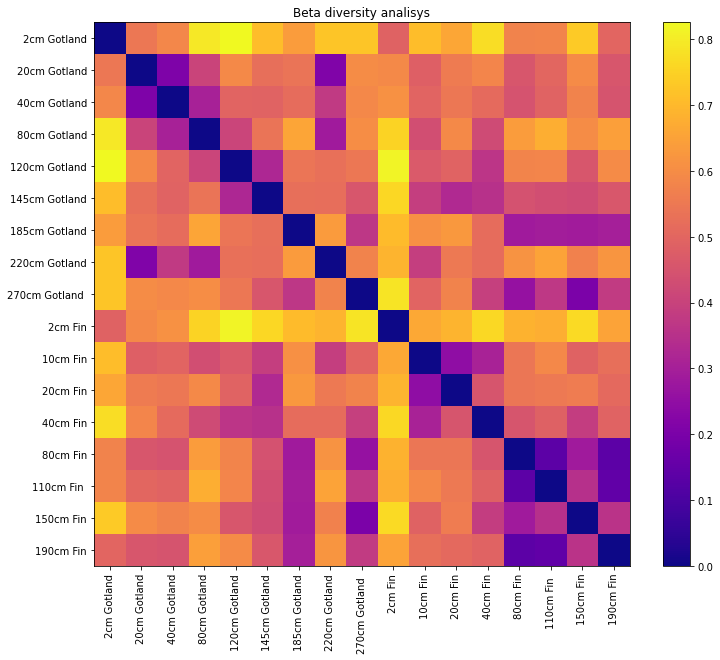

In [64]:
fig = dm.plot("plasma", "Beta diversity analisys")
fig.set_size_inches((12, 10))
plt.savefig("../figures/beta_braycurtis.png")

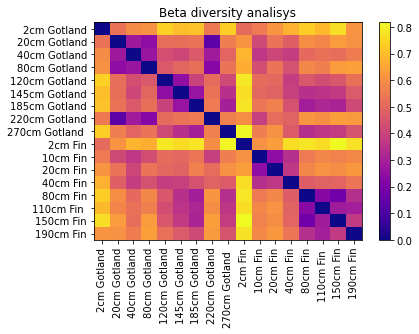

In [22]:
qiime_dm = pd.read_csv("../data/processed/beta_div_bray_curtis/bray_curtis_otu_table.txt", sep="\t", index_col=0)
fig = dm.plot("plasma", "Beta diversity analisys")

In [50]:
otu_names = list(map(lambda x: x.replace('_', " "), comp_otu.columns.values))
print(otu_names[:10])

['OTU 4', 'OTU 16', 'OTU 2', 'OTU 26', 'OTU 5', 'OTU 13', 'OTU 10', 'OTU 8', 'OTU 15', 'OTU 38']


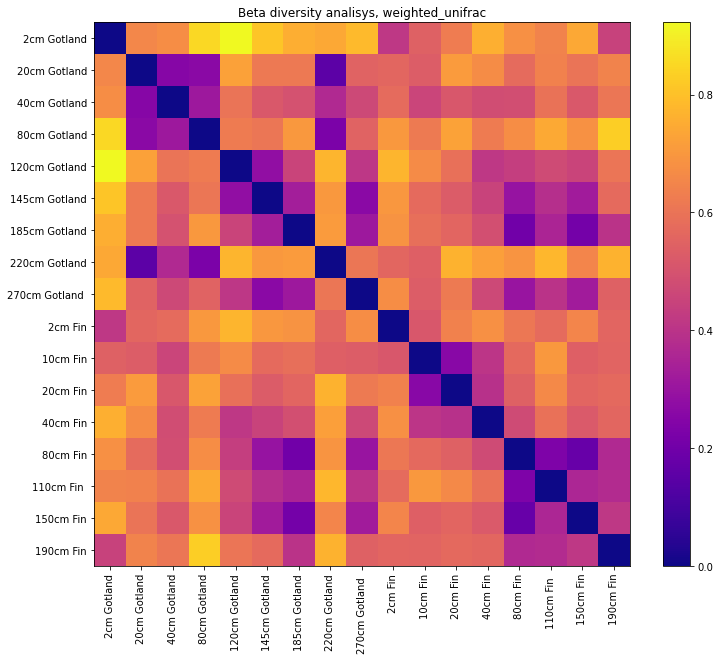

In [83]:
metrics = ["braycurtis", "unweighted_unifrac", "weighted_unifrac"]
metric = metrics[2]

if "unifrac" in metric:
    dm = diversity.beta_diversity(metric, comp_otu, comp_otu.index, otu_ids=otu_names, tree=tree)
else:
    dm = diversity.beta_diversity(metric, comp_otu, comp_otu.index)
    
fig = dm.plot("plasma", f"Beta diversity analisys, {metric}")
fig.set_size_inches((12, 10))
plt.savefig(f"../figures/beta_{metric}.png")

## NMDS

In [84]:
samples = comp_otu.index.values
metasamples = list(map(lambda x: x.split()[-1], samples))
depth = np.array(list(map(lambda x: int(x.split()[0][:-2]), samples)))
print(metasamples)
print(depth)

ms2ids = dict(zip(set(metasamples), range(len(set(metasamples)))))
ids2ms = {y: x for x, y in ms2ids.items()}
metasamples_ids = [ms2ids[x] for x in metasamples]

['Gotland', 'Gotland', 'Gotland', 'Gotland', 'Gotland', 'Gotland', 'Gotland', 'Gotland', 'Gotland', 'Fin', 'Fin', 'Fin', 'Fin', 'Fin', 'Fin', 'Fin', 'Fin']
[  2  20  40  80 120 145 185 220 270   2  10  20  40  80 110 150 190]


(17, 1225)
(17, 2)


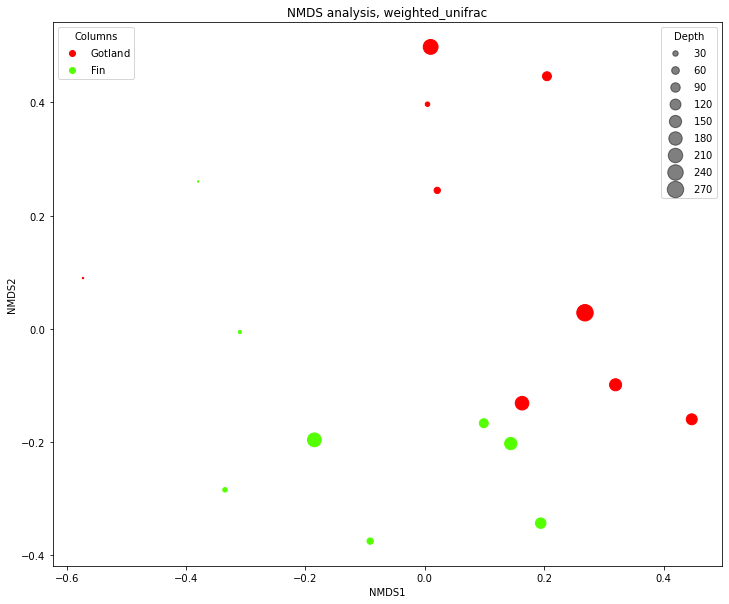

In [85]:
X = comp_otu.values
print(X.shape)
X = X[:200]
embedding = MDS(n_components=2, metric=True, n_jobs=-1, dissimilarity="precomputed")
X_transformed = embedding.fit_transform(dm.redundant_form())
print(X_transformed.shape)


# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=metasamples_ids, s=depth, cmap="prism")

# produce a legend with the unique colors from the scatter
handles0, labels0 = scatter.legend_elements()
labels0 = [re.sub("(\d)", lambda x: ids2ms[int(x.groups()[0])], labels0[0]), re.sub("(\d)", lambda x: ids2ms[int(x.groups()[0])], labels0[1])]

legend1 = ax.legend(handles0, labels0, loc="upper left", title="Columns")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
legend2 = ax.legend(handles, labels, loc="upper right", title="Depth")

plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.title(f"NMDS analysis, {metric}")
plt.savefig(f"../figures/NMDS_{metric}.png")
plt.show()

## Canonical correspondence analysis

In [188]:
ordination.cca?

Signature: ordination.cca(y, x, scaling=1)
Docstring:
Compute canonical (also known as constrained) correspondence

State: Experimental as of 0.4.0.
analysis.

Canonical (or constrained) correspondence analysis is a
multivariate ordination technique. It appeared in community
ecology [1]_ and relates community composition to the variation in
the environment (or in other factors). It works from data on
abundances or counts of samples and constraints variables,
and outputs ordination axes that maximize sample separation among species.

It is better suited to extract the niches of taxa than linear
multivariate methods because it assumes unimodal response curves
(habitat preferences are often unimodal functions of habitat
variables [2]_).

As more environmental variables are added, the result gets more
similar to unconstrained ordination, so only the variables that
are deemed explanatory should be included in the analysis.

Parameters
----------
y : DataFrame
    Samples by features table (